In [70]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
import seaborn as sns

In [2]:
wego = pd.read_csv("../data/headway.csv")

wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,...,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,...,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0


In [3]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                350329 non-null  int64  
 1   SERVICE_ABBR               350329 non-null  int64  
 2   ADHERENCE_ID               350329 non-null  int64  
 3   DATE                       350329 non-null  object 
 4   ROUTE_ABBR                 350329 non-null  int64  
 5   BLOCK_ABBR                 350329 non-null  int64  
 6   OPERATOR                   350329 non-null  int64  
 7   TRIP_ID                    350329 non-null  int64  
 8   OVERLOAD_ID                350329 non-null  int64  
 9   ROUTE_DIRECTION_NAME       350329 non-null  object 
 10  TIME_POINT_ABBR            350329 non-null  object 
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64
 12  TRIP_EDGE                  350329 non-null  int64  
 13  LATITUDE                   35

In [4]:
wego.shape

(350329, 30)

In [5]:
wego['ROUTE_ABBR'].value_counts().sort_index()

ROUTE_ABBR
3     47162
7     18026
22    25959
23    42108
50    43291
52    51819
55    61944
56    60020
Name: count, dtype: int64

In [6]:
wego['SCHEDULED_TIME']=pd.to_datetime(wego['SCHEDULED_TIME'])

Headway is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. Bunching occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. Gapping is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

Another important variable is adherence, which compares the actual departure time to the scheduled time and is included in the ADHERENCE column. A negative adherence value means that a bus left a time point late and a positive adherence indicates that the bus left the time point early. Buses with adherence values beyond negative 6 are generally considered late and beyond positive 1 are considered early. However, there is some additional logic where the staff applies waivers to allow early departures, such as an express bus that has already picked up everyone at a park-and-ride lot and is only dropping people off at the remaining stops, and also allows for early timepoint records for all records where TRIP_EDGE = 2 (end of trip), since it is not a problem if a bus ends its trip early as long as it didn't pass other timepoints early along the way. Note: When determining whether a bus is early or late, it is advised that you use the 'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', and 'ADJUSTED_ONTIME_COUNT' columns in order to account for the adjustments.

#### Goals of this project:

1.) What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

    calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY

2.) How does direction of travel, route, or location affect the headway and on-time performance?

3.) How does time of day or day of week affect headway and on-time performance?

4.) How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

5.) Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [7]:
wego[[
        'DATE', 'CALENDAR_ID', 'TRIP_ID', 'ROUTE_ABBR',
        'TIME_POINT_ABBR', 'TRIP_EDGE',
        'SCHEDULED_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
        'ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT'
    ]]

,DATE,CALENDAR_ID,TRIP_ID,ROUTE_ABBR,TIME_POINT_ABBR,TRIP_EDGE,SCHEDULED_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
0,2023-08-01,120230801,345104,22,MHSP,1,2023-08-01 04:42:00,2023-08-01 04:44:08,-2.133333,0,0,1
1,2023-08-01,120230801,345104,22,ELIZ,0,2023-08-01 04:46:00,2023-08-01 04:48:27,-2.450000,0,0,1
2,2023-08-01,120230801,345104,22,CV23,0,2023-08-01 04:54:00,2023-08-01 04:54:56,-0.933333,0,0,1
3,2023-08-01,120230801,345104,22,MCC5_10,2,2023-08-01 05:10:00,2023-08-01 05:03:43,6.283333,0,0,1
4,2023-08-01,120230801,345105,22,MCC5_10,1,2023-08-01 05:15:00,2023-08-01 05:16:35,-1.583333,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
350324,2023-09-30,120230930,353448,7,21BK,0,2023-09-30 22:23:00,2023-09-30 22:31:26,-8.433333,0,1,0
350325,2023-09-30,120230930,353448,7,MCC5_9,2,2023-09-30 22:38:00,2023-09-30 22:49:18,-11.300000,0,1,0
350326,2023-09-30,120230930,353449,7,MCC5_9,1,2023-09-30 22:45:00,2023-09-30 22:49:19,-4.316666,0,0,1
350327,2023-09-30,120230930,353449,7,21BK,0,2023-09-30 22:59:00,2023-09-30 23:21:05,-22.083333,0,1,0


# 1.) What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?


## overall on-time performance

In [8]:
(wego['ADJUSTED_ONTIME_COUNT'].sum()/350329)*100

#77% of all checkpoints are on time

77.08411236295025

## distribution of adherence

In [9]:
wego[['ADHERENCE']].apply(['min', 'max', 'mean', 'median'])

,ADHERENCE
min,-948.533333
max,88.383333
mean,-3.188796
median,-2.000000


In [10]:
wego['ADHERENCE'].describe()

count    338861.000000
mean         -3.188796
std           6.898842
min        -948.533333
25%          -4.566666
50%          -2.000000
75%          -0.333333
max          88.383333
Name: ADHERENCE, dtype: float64

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence')]

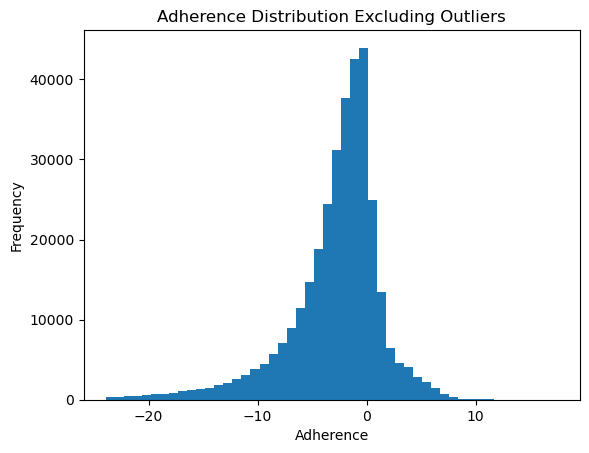

In [11]:
ad_mean = wego['ADHERENCE'].mean()
ad_std = np.std(wego['ADHERENCE'])
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50)
)
ax.set(
    title='Adherence Distribution Excluding Outliers',
    xlabel='Adherence'
    )

## distribution of headway
    calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY


In [12]:
wego['HDWY_DEV'].describe()

count    265893.000000
mean          0.518081
std           7.161798
min         -64.000000
25%          -2.316667
50%           0.033333
75%           2.483333
max         565.433333
Name: HDWY_DEV, dtype: float64

[Text(0.5, 1.0, 'HDWY Distribution Excluding Outliers'), Text(0.5, 0, 'HDWY')]

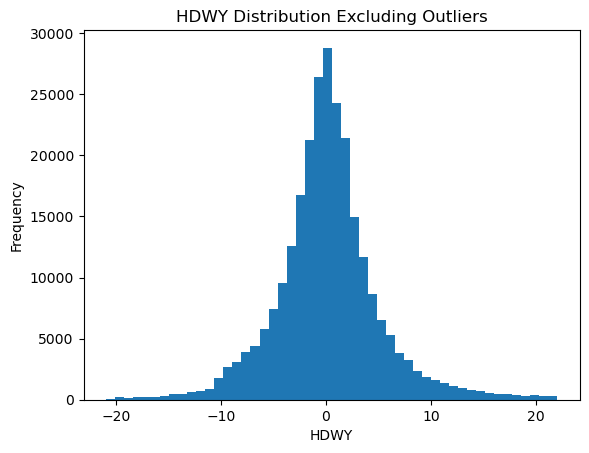

In [13]:
ad_mean = wego['HDWY_DEV'].mean()
ad_std = np.std(wego['HDWY_DEV'])
ax = (
    wego[wego['HDWY_DEV'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['HDWY_DEV']
    .plot(kind='hist',
          bins=50)
)
ax.set(
    title='HDWY Distribution Excluding Outliers',
    xlabel='HDWY'
    )

Headway is the amount of time between a bus and the prior bus at the same stop. In the dataset, the amount of headway scheduled is contained in the SCHEDULED_HDWY column and indicates the difference between the scheduled time for a particular stop and the scheduled time for the previous bus on that same stop.

This dataset contains a column HDWY_DEV, which shows the amount of deviation from the scheduled headway. Bunching occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. Gapping is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY.

The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

In [64]:
wego['HDWY_DEV_PERC'] = wego['HDWY_DEV']/wego['SCHEDULED_HDWY']


In [66]:
deviation = wego[['HDWY_DEV_PERC','HDWY_DEV','SCHEDULED_HDWY']]
deviation

,HDWY_DEV_PERC,HDWY_DEV,SCHEDULED_HDWY
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
350324,0.175556,5.266666,30.0
350325,NaN,NaN,NaN
350326,0.062222,1.866666,30.0
350327,0.583333,17.500000,30.0


In [67]:
deviation2 = deviation.dropna(axis = 0, how='any')
deviation2

,HDWY_DEV_PERC,HDWY_DEV,SCHEDULED_HDWY
7,0.076190,2.666666,35.0
8,0.056190,1.966666,35.0
9,-0.032222,-0.483334,15.0
11,-0.144444,-2.166667,15.0
12,-0.258889,-3.883334,15.0
...,...,...,...
350320,0.223889,6.716666,30.0
350323,0.163889,4.916666,30.0
350324,0.175556,5.266666,30.0
350326,0.062222,1.866666,30.0


In [68]:
deviation2['BUNCHING'] = deviation2['HDWY_DEV_PERC'] <-0.5
deviation2['GAPPING'] = deviation2['HDWY_DEV_PERC'] > 0.5
deviation2['ACCEPTABLE'] = (deviation2['HDWY_DEV_PERC'] >=-0.5) & (deviation2['HDWY_DEV_PERC'] <= 0.5)
deviation2

C:\Users\KatieClay\AppData\Local\Temp\ipykernel_43524\2282433875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deviation2['BUNCHING'] = deviation2['HDWY_DEV_PERC'] <-0.5
C:\Users\KatieClay\AppData\Local\Temp\ipykernel_43524\2282433875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deviation2['GAPPING'] = deviation2['HDWY_DEV_PERC'] > 0.5
C:\Users\KatieClay\AppData\Local\Temp\ipykernel_43524\2282433875.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,HDWY_DEV_PERC,HDWY_DEV,SCHEDULED_HDWY,BUNCHING,GAPPING,ACCEPTABLE
7,0.076190,2.666666,35.0,False,False,True
8,0.056190,1.966666,35.0,False,False,True
9,-0.032222,-0.483334,15.0,False,False,True
11,-0.144444,-2.166667,15.0,False,False,True
12,-0.258889,-3.883334,15.0,False,False,True
...,...,...,...,...,...,...
350320,0.223889,6.716666,30.0,False,False,True
350323,0.163889,4.916666,30.0,False,False,True
350324,0.175556,5.266666,30.0,False,False,True
350326,0.062222,1.866666,30.0,False,False,True


In [92]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350329 non-null  int64         
 1   SERVICE_ABBR               350329 non-null  int64         
 2   ADHERENCE_ID               350329 non-null  int64         
 3   DATE                       350329 non-null  object        
 4   ROUTE_ABBR                 350329 non-null  int64         
 5   BLOCK_ABBR                 350329 non-null  int64         
 6   OPERATOR                   350329 non-null  int64         
 7   TRIP_ID                    350329 non-null  int64         
 8   OVERLOAD_ID                350329 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350329 non-null  object        
 10  TIME_POINT_ABBR            350329 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64 

# Q2.) How does direction of travel, route, or location affect the headway and on-time performance?


In [110]:
wego = wego.dropna(subset= ['ADHERENCE','SCHEDULED_HDWY', 'ACTUAL_HDWY' ])
wego.sort_values('ADHERENCE', ascending = True)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,ACCEPTED_DEV,HDWY_DEV_PERC
103162,120230818,1,99963004,2023-08-18,52,5202,1052,352052,0,FROM DOWNTOWN,...,0,1,0,0,0.0,0,956.500000,8.0,1.038889,1.038889
19788,120230804,1,99559760,2023-08-04,22,2211,1743,350239,0,FROM DOWNTOWN,...,0,1,0,0,0.0,0,686.800000,5.0,-0.451111,-0.451111
340625,120230929,1,100377605,2023-09-29,23,2312,1394,350478,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,595.666666,2.0,0.140278,0.140278
30377,120230806,3,99601907,2023-08-06,23,2311,2642,350455,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,515.800000,2.0,-0.064167,-0.064167
229460,120230910,3,100599172,2023-09-10,23,2311,2642,350455,0,TO DOWNTOWN,...,0,1,0,0,0.0,0,513.333333,2.0,2.260000,2.260000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6167,120230801,1,99465648,2023-08-01,7,700,3144,348432,0,TO DOWNTOWN,...,1,0,0,0,0.0,0,5.116666,8.0,0.016667,0.016667
6156,120230801,1,99465637,2023-08-01,7,700,3144,348428,0,TO DOWNTOWN,...,1,0,0,0,0.0,0,0.000000,NaN,0.295370,0.295370
6168,120230801,1,99465649,2023-08-01,7,700,3144,348432,0,TO DOWNTOWN,...,1,0,0,0,0.0,0,0.000000,NaN,-0.080000,-0.080000
6149,120230801,1,99465630,2023-08-01,7,700,3144,348426,0,TO DOWNTOWN,...,1,0,0,0,0.0,0,11.100000,19.0,-0.203333,-0.203333


## ROUTE DIRECTION

In [106]:
direction = wego.groupby('ROUTE_DIRECTION_NAME')[["ADJUSTED_LATE_COUNT", 'ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT']].sum()
direction


,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_DIRECTION_NAME,,,
FROM DOWNTOWN,30894,4511,105987
TO DOWNTOWN,14937,4252,105312


In [107]:
direction = direction.rename(columns = {'ADJUSTED_LATE_COUNT':'late_total',
                                       'ADJUSTED_EARLY_COUNT': 'early_total',
                                       'ADJUSTED_ONTIME_COUNT': 'ontime_total'})
direction

,late_total,early_total,ontime_total
ROUTE_DIRECTION_NAME,,,
FROM DOWNTOWN,30894,4511,105987
TO DOWNTOWN,14937,4252,105312


## ROUTE NUMBER

In [108]:
route = wego.groupby('ROUTE_ABBR')[["ADJUSTED_LATE_COUNT", 'ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT']].sum()
route

,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADJUSTED_ONTIME_COUNT
ROUTE_ABBR,,,
3,7235,1271,28077
7,1966,348,9264
22,1367,577,15063
23,2258,1104,25116
50,4309,975,29309
52,7856,1402,30629
55,13370,1452,34610
56,7470,1634,39231


In [109]:
route = route.rename(columns = {'ADJUSTED_LATE_COUNT':'late_total',
                                       'ADJUSTED_EARLY_COUNT': 'early_total',
                                       'ADJUSTED_ONTIME_COUNT': 'ontime_total'})
route

,late_total,early_total,ontime_total
ROUTE_ABBR,,,
3,7235,1271,28077
7,1966,348,9264
22,1367,577,15063
23,2258,1104,25116
50,4309,975,29309
52,7856,1402,30629
55,13370,1452,34610
56,7470,1634,39231


## LOCATION

In [103]:
location = wego.groupby('TIME_POINT_ABBR')[["ADJUSTED_LATE_COUNT", 'ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT']].sum()
location

,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,ADJUSTED_ONTIME_COUNT
TIME_POINT_ABBR,,,
21BK,1413,189,4293
25ACLARK,38,18,2335
28&CHARL,881,204,5951
ARTS,30,4,73
BRCJ,821,125,3063
...,...,...,...
WE23,1865,354,6072
WE31,1852,309,6136
WHBG,2128,358,8868


In [116]:
wego_avg_route = wego[['ROUTE_ABBR','ROUTE_DIRECTION_NAME','HDWY_DEV_PERC', 'ADHERENCE']].groupby(['ROUTE_ABBR','ROUTE_DIRECTION_NAME']).mean('HDWY_DEV_PERC', 'ADHERENCE')
wego_avg_route

HDWY_DEV_PERC  ADHERENCE
ROUTE_ABBR ROUTE_DIRECTION_NAME                          
3          FROM DOWNTOWN              0.084821  -4.800548
           TO DOWNTOWN                0.027764  -2.756597
7          FROM DOWNTOWN              0.021202  -3.990586
           TO DOWNTOWN                0.022637  -2.745362
22         FROM DOWNTOWN              0.041202  -2.643126
           TO DOWNTOWN                0.025774  -1.487543
23         FROM DOWNTOWN              0.053438  -2.594532
           TO DOWNTOWN                0.056034  -2.010432
50         FROM DOWNTOWN              0.011373  -3.185747
           TO DOWNTOWN                     inf  -2.555356
52         FROM DOWNTOWN              0.052448  -5.169648
           TO DOWNTOWN                0.029981  -2.807824
55         FROM DOWNTOWN              0.023171  -5.690817
           TO DOWNTOWN                     inf  -4.086525
56         FROM DOWNTOWN              0.014636  -3.711822
           TO DOWNTOWN                     inf  -2.190948

In [119]:
wego['BUNCHING'] = wego['HDWY_DEV_PERC'] <-0.5
wego['GAPPING'] = wego['HDWY_DEV_PERC'] > 0.5
wego['ACCEPTABLE'] = (wego['HDWY_DEV_PERC'] >=-0.5) & (wego['HDWY_DEV_PERC'] <= 0.5)
wego

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,ACCEPTED_DEV,HDWY_DEV_PERC,BUNCHING,GAPPING,ACCEPTABLE
7,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,0.0,0,13.216666,10.0,0.076190,0.076190,False,False,True
8,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,0.056190,0.056190,False,False,True
9,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,-0.032222,-0.032222,False,False,True
11,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,0,0.0,0,10.800000,5.0,-0.144444,-0.144444,False,False,True
12,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,0,0.0,0,0.000000,NaN,-0.258889,-0.258889,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350320,120230930,2,100406606,2023-09-30,7,702,2312,353447,0,FROM DOWNTOWN,...,0,0.0,0,7.033333,NaN,0.223889,0.223889,False,False,True
350323,120230930,2,100406609,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.0,0,1.966666,5.0,0.163889,0.163889,False,False,True
350324,120230930,2,100406610,2023-09-30,7,702,2312,353448,0,TO DOWNTOWN,...,0,0.0,0,0.000000,NaN,0.175556,0.175556,False,False,True
350326,120230930,2,100406612,2023-09-30,7,702,2312,353449,0,FROM DOWNTOWN,...,0,0.0,0,0.000000,NaN,0.062222,0.062222,False,False,True


In [122]:
route_headway = wego[["ROUTE_DIRECTION_NAME", "ROUTE_ABBR", "BUNCHING", "GAPPING", "ACCEPTABLE"]].groupby(['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']).agg('sum')
#"BUNCHING", "GAPPING", "ACCEPTED")
route_headway

BUNCHING  GAPPING  ACCEPTABLE
ROUTE_ABBR ROUTE_DIRECTION_NAME                               
3          FROM DOWNTOWN             1443     1829       15010
           TO DOWNTOWN                736     1115       16450
7          FROM DOWNTOWN              287      377        5221
           TO DOWNTOWN                176      238        5279
22         FROM DOWNTOWN              212      489        8246
           TO DOWNTOWN                 85      250        7725
23         FROM DOWNTOWN              486     1157       15140
           TO DOWNTOWN                244      789       10662
50         FROM DOWNTOWN              659      790       15836
           TO DOWNTOWN                397      618       16293
52         FROM DOWNTOWN             2051     2533       16105
           TO DOWNTOWN                958     1295       16945
55         FROM DOWNTOWN             3870     3642       17026
           TO DOWNTOWN               2699     2842       19353
56         FROM DOWNTOWN             2747     2898       23338
           TO DOWNTOWN                949     1111       17289

<Axes: xlabel='ROUTE_ABBR', ylabel='ontime_total'>

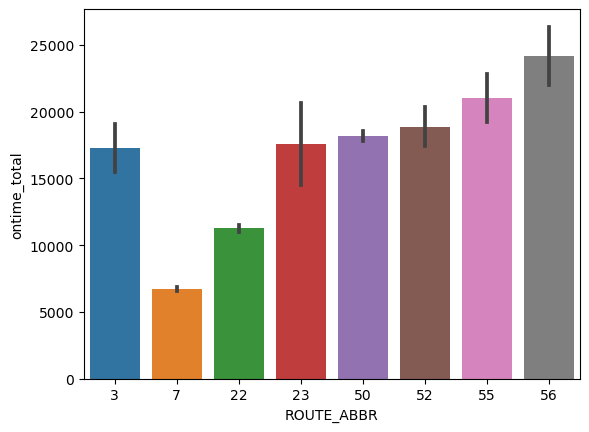

In [77]:
sns.barplot(x = 'ROUTE_ABBR',
            y = 'ontime_total',
           data = direction)

<Axes: xlabel='ROUTE_ABBR', ylabel='late_total'>

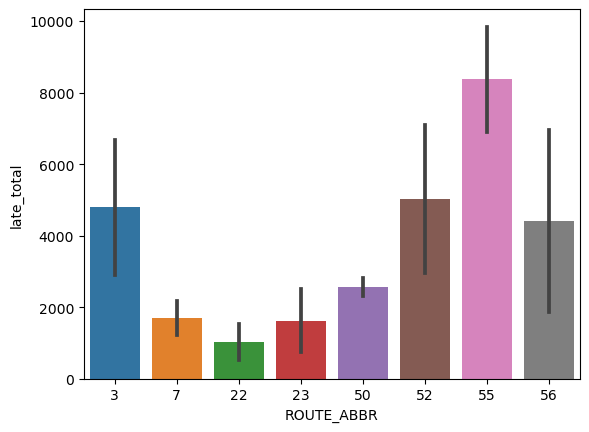

In [78]:
sns.barplot(x = 'ROUTE_ABBR',
            y = 'late_total',
           data = direction)

In [ ]:
headway = wego[['ROUTE_DIRECTION_NAME','ROUTE_ABBR','ACTUAL_HDWY']].groupby(['ROUTE_DIRECTION_NAME','ROUTE_ABBR']).agg(['min', 'max', 'mean'])
headway

### Q2 Answer: directions from downtown is ontime less than to downtown

# Q3.) How does time of day or day of week affect headway and on-time performance?


In [ ]:
wego.info()

In [ ]:
wego.head()

In [ ]:
#date to weekday
time = wego['DATE'].dt.week